#   Bibliotecas

- Versões das bibliotecas no README

In [94]:
import pandas as pd
import random 
import numpy as np
import re
from scipy.sparse import hstack #utilizada para a junção de matrizes

In [95]:
#Pré processamento de colunas

from sklearn.model_selection import train_test_split #Divisão do dataset entre treino e teste
from sklearn.feature_extraction.text import TfidfVectorizer #vetorização do dataset
from sklearn.preprocessing import OneHotEncoder #aplicação de dummy

In [96]:
#Pré processamento de texto


import nltk
from nltk import word_tokenize #tokenizador
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords   #stopword

stop_words = stopwords.words('english')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\angel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\angel\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [97]:
#import de funções do script de pre_processamento

from pre_processamento import pre_processamento, text_preprocess, textcolumns_junct,stemming

In [98]:
# Modelo a ser testado

from lightgbm import LGBMRegressor

In [99]:
#metricas

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error

In [100]:
train = pd.read_csv(r"C:\Users\angel\Desktop\bootcamp\train.tsv", sep='\t')
test = pd.read_csv(r"C:\Users\angel\Desktop\bootcamp\test.tsv", sep='\t')

In [101]:
train,test = pre_processamento(train,test)

#   Pré-processamento 

In [102]:
train = textcolumns_junct(train) #Função pra juntar as colunas de texto em uma só coluna

In [103]:
#Convertendo tudo para string

train["item_description"] = train["item_description"].astype(str)

In [104]:
train["item_description"] = train["item_description"].apply(lambda x: text_preprocess(x)) #Limpando texto com regex.


In [105]:
train["item_description"] = train["item_description"].apply(lambda x: word_tokenize(x)) #tokenizando

In [106]:
train["item_description"] = train["item_description"].apply(lambda x: stemming(x))

In [107]:
train["item_description"]=[" ".join(review) for review in train["item_description"].values]

In [108]:
train["item_description"]

0              mlb cincinnati red shirt size xl descript yet
1          razer blackwidow chroma keyboard razer keyboar...
2          ava viv blous target ador top hint lace key ho...
3          leather hors statu new tag . leather hors . re...
4                 24k gold plate rose complet certif authent
                                 ...                        
1482530    free peopl inspir dress free peopl lace say si...
1482531    littl mermaid handmad dress disney littl merma...
1482532    21 day fix contain eat plan use twice still gr...
1482533    world market lantern 2 one see 2 red 2 orang 2...
1482534    brand new lux de vill wallet new tag red spark...
Name: item_description, Length: 1481661, dtype: object

In [110]:
train.shape

(1481661, 11)

#   Split

In [111]:
train1 = train.drop(train[~((train['price'] > 0) & (train['price'] <= 250))].index)

In [112]:
train1.shape

(1475534, 11)

In [113]:
X = train1.drop("price", axis = 1)
y = train1["price"]

In [142]:
#Separação em treino e teste para começarmos as transformaçõs, protegendo nossos dados de teste de possíveis vazamentos e das mudanças de hyperparametros. 

X1, Xtest, y1, ytest = train_test_split(X, y, test_size=0.1, random_state=10) #Divisão em 90/10

In [143]:
#Separação em treino e teste para começarmos as transformaçõs, protegendo nossos dados de validação de possíveis vazamentos. 

Xtrain, Xval, ytrain, yval = train_test_split(X1, y1, test_size=0.2, random_state=10) #Divisão em 80/20

<AxesSubplot:>

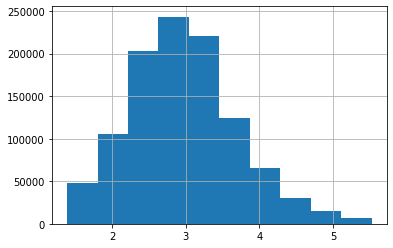

In [144]:
#Normalizando, com log, o target (price), foi realizado de forma separada para nao terem dados vazados.

ytrain =  np.log1p(ytrain)
ytrain.hist()

In [145]:
print(Xtrain.shape,ytrain.shape) 
print(Xval.shape,yval.shape)
print(Xtest.shape,ytest.shape)

(1062384, 10) (1062384,)
(265596, 10) (265596,)
(147554, 10) (147554,)


# Transformadores

In [148]:
vec = TfidfVectorizer(stop_words=stop_words, ngram_range=(1,2), max_features=50000) #vetorização, com stop word. 

In [149]:
vec_train = vec.fit_transform(Xtrain["item_description"])

vec_train

<1062384x50000 sparse matrix of type '<class 'numpy.float64'>'
	with 28444564 stored elements in Compressed Sparse Row format>

In [150]:
vec_val = vec.transform(Xval["item_description"])

vec_val

<265596x50000 sparse matrix of type '<class 'numpy.float64'>'
	with 7105732 stored elements in Compressed Sparse Row format>

In [151]:
ohe = OneHotEncoder(handle_unknown="ignore")

#aplicação dummy nas colunas categóricas.

ohe_train = ohe.fit_transform(Xtrain[["item_condition_id",   
                                         "shipping",
                                         "gen_cat",
                                         "sub1_cat",
                                         "sub2_cat", 
                                                    ]])
                            
ohe_train

<1062384x985 sparse matrix of type '<class 'numpy.float64'>'
	with 5311920 stored elements in Compressed Sparse Row format>

In [152]:
ohe_val = ohe.transform(Xval[["item_condition_id",   
                                         "shipping",
                                         "gen_cat",
                                         "sub1_cat",
                                         "sub2_cat", 
                                                    ]])

ohe_val

<265596x985 sparse matrix of type '<class 'numpy.float64'>'
	with 1327960 stored elements in Compressed Sparse Row format>

In [153]:
#juntando cada matrix gerada por cada pré-processamento

x_train = hstack([
                 (vec_train),
                 (ohe_train)
                            ]) 
x_train

<1062384x50985 sparse matrix of type '<class 'numpy.float64'>'
	with 33756484 stored elements in Compressed Sparse Row format>

In [154]:
x_val = hstack([
                 (vec_val),
                 (ohe_val),
                             ]) 
x_val

<265596x50985 sparse matrix of type '<class 'numpy.float64'>'
	with 8433692 stored elements in Compressed Sparse Row format>

# Modelo

In [155]:
lgb = LGBMRegressor(device = "gpu", random_state=10)

In [156]:
model = lgb.fit(x_train, ytrain)

#Aproximadamente  6minutos para treino

In [158]:
ypredict = model.predict(x_val)

#Aproximadamente 0.7s para predição

In [157]:
ypredict_train = model.predict(x_train)

In [159]:
ypredict = np.expm1(ypredict)


#   Resultado

- predict validação

In [160]:
print('MAE: $ %.2f' %  mean_absolute_error(yval,ypredict))
print('RMSE:  $ %.2f' %  (mean_squared_error(yval,ypredict)**0.5))
print('RMSLE: %2f' % mean_squared_log_error(yval,ypredict))


MAE: $ 10.85
RMSE:  $ 21.20
RMSLE: 0.274586


- predict treino

In [161]:
print('MAE_train: $%2f' % mean_absolute_error(ytrain,ypredict_train))
print('RMSE_train: $%2f' % (mean_squared_error(ytrain,ypredict_train)**0.5))
print('RMSLE_train: %2f' % mean_squared_log_error(ytrain,ypredict_train))

MAE_train: $0.405012
RMSE_train: $0.522888
RMSLE_train: 0.017431
